In [ ]:
# Mount Google Drive for dataset storage and checkpointing
from google.colab import drive
import os
import zipfile
import random

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings

# To suppress all warnings
warnings.filterwarnings('ignore')

In [ ]:
# Install dependencies
!pip install timm

# Import packages
import os
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from datetime import datetime
import timm  # EfficientNet models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

In [ ]:
# Unzip dataset
import os
import zipfile

zip_path = '/content/drive/MyDrive/400mal_600ben/400mal_600ben_224.zip'
extract_path = '/content/400mal_600ben'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

print("Unzipping...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzip complete!")

# Print directory structure
print("\nFile structure:")
for root, dirs, files in os.walk(extract_path):
    print(f" {root}")
    for f in files[:5]:
        print(f"   - {f}")

Unzipping...
Unzip complete!

File structure:
 /content/400mal_600ben
 /content/400mal_600ben/400mal_600ben_224
   - ISIC_3435596.jpg
   - ISIC_3338629.jpg
   - ISIC_8967404.jpg
   - ISIC_8959657.jpg
   - ISIC_8838213.jpg
 /content/400mal_600ben/__MACOSX
 /content/400mal_600ben/__MACOSX/400mal_600ben_224
   - ._ISIC_0517460.jpg
   - ._ISIC_9625875.jpg


# **1. DATA DECLARATION**

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCHS = 15
VERBOSE = True
PRINT_FREQ = 50

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Paths
CSV_PATH = '/content/drive/MyDrive/ISIC_2020_Training_GroundTruth.csv'
IMAGE_DIR = '/content/400mal_600ben/400mal_600ben_224'

Using device: cuda


#**2. DATASET & DATALOADER**

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import pandas as pd

class JPEGDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]["image_name"] + ".jpg")
        try:
            image = Image.open(img_name).convert("RGB")
            if self.transform:
                image = self.transform(image)
            label = self.dataframe.iloc[idx]["target"]
            return image, torch.tensor(label, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading {img_name}: {str(e)}")
            dummy_img = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            return dummy_img, torch.tensor(0.0, dtype=torch.float32)

def prepare_data_with_test(csv_path, image_dir, test_size=0.1, val_size=0.1):
    df = pd.read_csv(csv_path)
    existing = set(os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(".jpg"))
    df = df[df["image_name"].isin(existing)][["image_name", "target"]].dropna()

    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df["target"])
    val_frac = val_size / (1 - test_size)
    train_df, val_df = train_test_split(train_val_df, test_size=val_frac, random_state=42, stratify=train_val_df["target"])

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_loader = DataLoader(JPEGDataset(train_df, image_dir, transform), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(JPEGDataset(val_df, image_dir, transform), batch_size=BATCH_SIZE)
    test_loader = DataLoader(JPEGDataset(test_df, image_dir, transform), batch_size=BATCH_SIZE)
    full_train_loader = DataLoader(JPEGDataset(train_val_df, image_dir, transform), batch_size=BATCH_SIZE, shuffle=True)

    return train_loader, val_loader, test_loader, full_train_loader, train_val_df, test_df


#**3. MODEL TRAINING LOOP**

In [ ]:
# MODEL SETUP
def setup_model():
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
    model = model.to(DEVICE)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)
    return model, criterion, optimizer, scheduler

In [ ]:
# MODEL TRAIN
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, save_path, epochs=EPOCHS):
    best_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        avg_train_loss = total_loss / len(train_loader.dataset)

        val_loss, val_metrics = evaluate_model(model, criterion, val_loader)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {val_metrics['auc']:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Saved best model.")

# **4. EVALUATION**

In [ ]:
# EVALUATION
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np

def evaluate_model(model, criterion, loader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader.dataset), {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs),
        'fpr': roc_curve(all_labels, all_probs)[0],
        'tpr': roc_curve(all_labels, all_probs)[1]
    }

# **5. GRAD-CAM**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_last_conv_layer(model):
    try:
        return model.features[-1]
    except AttributeError:
        return model.conv_head

def generate_gradcam(model, image_tensor):
    model.eval()
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    target_layer = get_last_conv_layer(model)
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_backward_hook(backward_hook)

    output = model(image_tensor.unsqueeze(0).to(DEVICE)).squeeze()

    if output.dim() == 0:
        pred_prob = torch.sigmoid(output).item()
        pred_label = int(pred_prob > 0.5)
        target_score = output
    else:
        pred_prob = torch.softmax(output, dim=-1)
        pred_label = torch.argmax(pred_prob).item()
        target_score = output[pred_label]

    model.zero_grad()
    target_score.backward(retain_graph=True)

    grads = gradients[0].detach().cpu().numpy()[0]
    acts = activations[0].detach().cpu().numpy()[0]

    weights = grads.mean(axis=(1, 2))

    cam = np.sum(weights[:, None, None] * acts, axis=0)

    cam = np.maximum(cam, 0)

    cam = cv2.resize(cam, (IMAGE_SIZE, IMAGE_SIZE))

    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
    cam = (cam * 255).astype(np.uint8)

    handle_f.remove()
    handle_b.remove()

    gradients.clear()
    activations.clear()

    return cam, pred_prob, pred_label

def overlay_cam_on_image(img_original_pil, cam):
    img_np = np.asarray(img_original_pil).astype(np.float32)

    original_width, original_height = img_original_pil.size

    heatmap_resized = cv2.resize(cam, (original_width, original_height))

    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    img_np_normalized = img_np / 255.0
    heatmap_colored_normalized = heatmap_colored / 255.0

    overlay = heatmap_colored_normalized * 0.4 + img_np_normalized * 0.6

    overlay = np.clip(overlay, 0, 1) * 255

    overlay = overlay.astype(np.uint8)

    return overlay

def predict_image_with_gradcam(model, image_path):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_original_pil = Image.open(image_path).convert("RGB")

    image_tensor = transform(img_original_pil)

    cam, prob, label = generate_gradcam(model, image_tensor)

    overlay_img = overlay_cam_on_image(img_original_pil, cam)

    class_name = 'Malignant' if label else 'Benign'
    print(f"Prediction: {class_name} (Prob: {prob:.4f})")

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(img_original_pil)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_img)
    plt.title(f"Grad-CAM ({class_name})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# **6. MAIN EXECUTION**

In [ ]:
%%time
train_loader, val_loader, test_loader, full_train_loader, train_val_df, test_df = prepare_data_with_test(CSV_PATH, IMAGE_DIR)

model_normal, criterion, optimizer, scheduler = setup_model()
MODEL_PATH = '/content/drive/MyDrive/efficientnet_model_normal.pth'

train_model(model_normal, criterion, optimizer, scheduler, train_loader, val_loader, MODEL_PATH)

model_normal.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model_normal.to(DEVICE)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/15 | Train Loss: 2.6475 | Val Loss: 1.5974 | AUC: 0.7777
Saved best model.
Epoch 2/15 | Train Loss: 0.5627 | Val Loss: 1.5088 | AUC: 0.7765
Saved best model.
Epoch 3/15 | Train Loss: 0.1642 | Val Loss: 1.5000 | AUC: 0.7658
Saved best model.
Epoch 4/15 | Train Loss: 0.0880 | Val Loss: 1.4452 | AUC: 0.7775
Saved best model.
Epoch 5/15 | Train Loss: 0.0585 | Val Loss: 1.4882 | AUC: 0.7785
Epoch 6/15 | Train Loss: 0.0542 | Val Loss: 1.4119 | AUC: 0.7944
Saved best model.
Epoch 7/15 | Train Loss: 0.0540 | Val Loss: 1.4055 | AUC: 0.8002
Saved best model.
Epoch 8/15 | Train Loss: 0.0560 | Val Loss: 1.3643 | AUC: 0.8004
Saved best model.
Epoch 9/15 | Train Loss: 0.0314 | Val Loss: 1.3677 | AUC: 0.7998
Epoch 10/15 | Train Loss: 0.0216 | Val Loss: 1.4691 | AUC: 0.7915
Epoch 11/15 | Train Loss: 0.0366 | Val Loss: 1.4208 | AUC: 0.8040
Epoch 12/15 | Train Loss: 0.0261 | Val Loss: 1.4611 | AUC: 0.7994
Epoch 13/15 | Train Loss: 0.0154 | Val Loss: 1.4526 | AUC: 0.7981
Epoch 14/15 | Train Loss:

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

Prediction: Malignant (Prob: 1.0000)


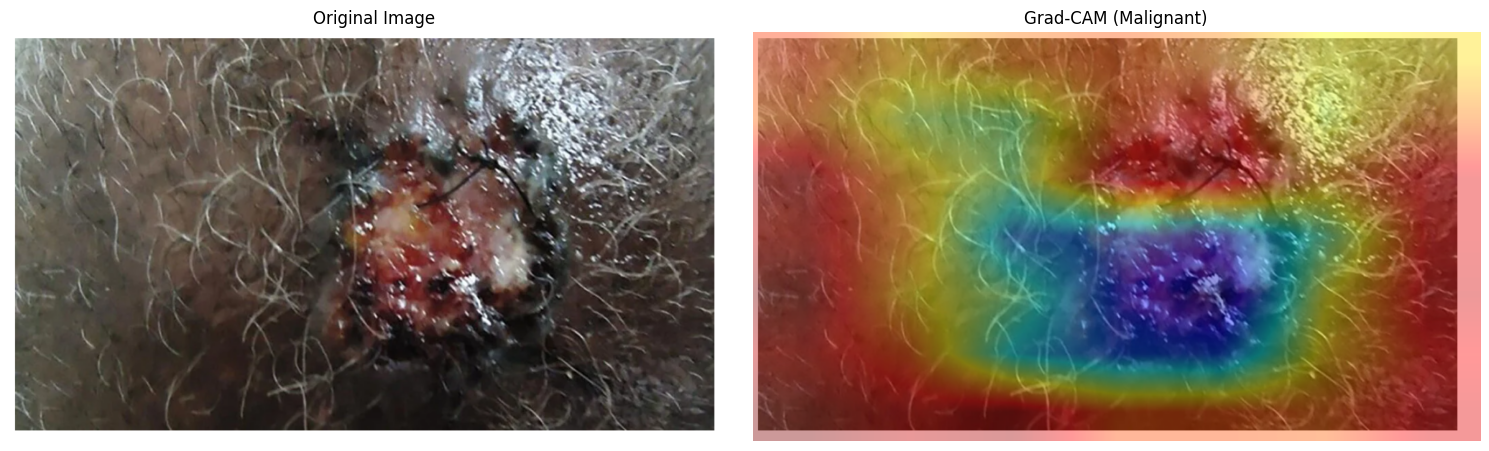

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/EfficientNet + GradCAM/darkskin_tumor_2.png'
predict_image_with_gradcam(model_normal, image_path)

Prediction: Benign (Prob: 0.1366)


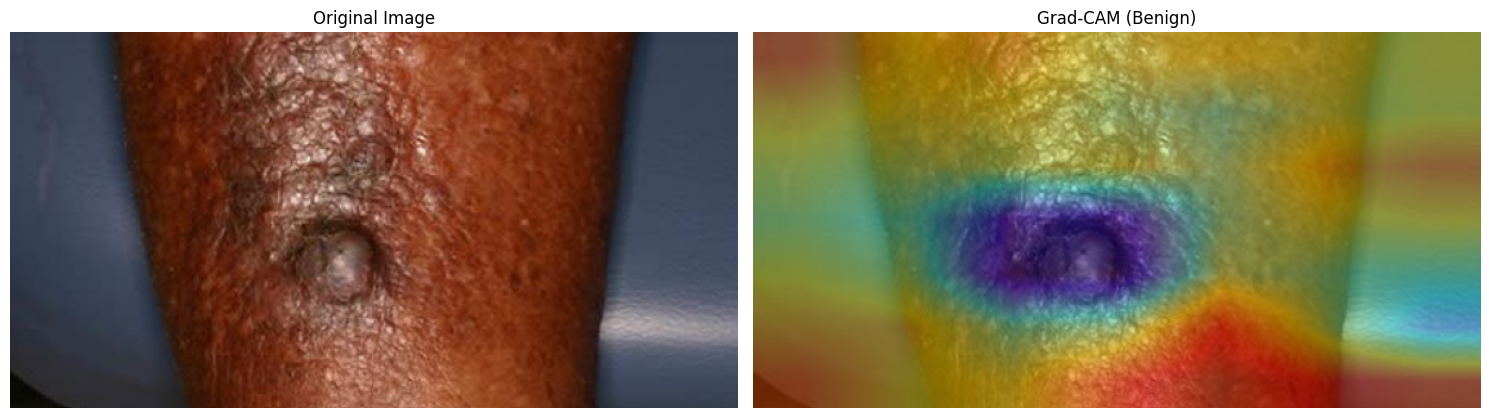

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/EfficientNet + GradCAM/darkskin_tumor_5.png'
predict_image_with_gradcam(model_normal, image_path)